<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Currency_%26_Oil_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [4]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


In [5]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [6]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

In [7]:

OilPriceInUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,CurrentDate).reset_index()
OilPriceInUSD['Date'] = pd.to_datetime(OilPriceInUSD['Date']).dt.date
OilPriceInUSD.set_index('Date', inplace=True)
OilPriceInUSD

OilPriceInUSD=OilPriceInUSD.asfreq('b')
OilPriceInUSD['Original_Oil_Price']=OilPriceInUSD.Value.fillna(method='bfill')
df_Oil_InUSD=OilPriceInUSD[['Original_Oil_Price']]
df_Oil_InUSD

,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09
...,...
2023-07-03,76.12
2023-07-04,76.18
2023-07-05,76.60


In [8]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,CurrentDate).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Original_USD_EUR_Price']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Original_USD_EUR_Price']].iloc[1:]
df_USD_EUR = df_USD_EUR[df_USD_EUR.index.isin(df_Oil_InUSD.index)]
df_USD_EUR

,Original_USD_EUR_Price
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974
...,...
2023-07-03,1.090750
2023-07-04,1.091310
2023-07-05,1.088495


In [9]:
df_USD_EUR[df_USD_EUR.index.isin(df_Oil_InUSD.index)]


,Original_USD_EUR_Price
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974
...,...
2023-07-03,1.090750
2023-07-04,1.091310
2023-07-05,1.088495


In [10]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime('2019-01-01')
train_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')


In [11]:
train_data_oil = df_Oil_InUSD[(df_Oil_InUSD.index >= train_start_date) & (df_Oil_InUSD.index <= train_end_date)]
test_data_oil = df_Oil_InUSD[df_Oil_InUSD.index >= test_start_date]
train_data_oil.head(5)



,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09


In [12]:
train_data_currency = df_USD_EUR[(df_USD_EUR.index >= train_start_date) & (df_USD_EUR.index <= train_end_date)]
test_data_currency = df_USD_EUR[df_USD_EUR.index >= test_start_date]
train_data_currency.head(5)

,Original_USD_EUR_Price
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974


In [13]:
from pmdarima import auto_arima
model = auto_arima(train_data_oil['Original_Oil_Price'].dropna(),
                   start_p=1, max_p=5, start_q=1, max_q=5, start_d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4031.353, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4018.777, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4020.684, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4020.532, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4022.532, Time=0.68 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4023.944, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4018.836, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4020.721, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4022.438, Time=0.97 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4022.532, Time=1.03 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4013.416, Time=2.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4020.649, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4020.573, Time=1.35 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4010.821, Time=1.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4020.136, Time=2.40 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1991.204
Date:                Mon, 10 Jul 2023   AIC                           3996.409
Time:                        21:40:19   BIC                           4031.051
Sample:                    01-02-2019   HQIC                          4009.549
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0826      0.182      0.453      0.650      -0.275       0.440
ar.L1         -1.4324      0.035    -40.948      0.000      -1.501      -1.364
ar.L2         -0.6520      0.049    -13.231      0.000      -0.749      -0.555
ar.L3          0.1782      0.023      7.791      0.000       0.133       0.223
ma.L1          1.5645      0.026     61.339      0.000       1.514       1.614
ma.L2          0.9130      0.026     35.323      0.000       0.862       0.964
sigma2         2.6742      0.051     52.099      0.000       2.574       2.775
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              5422.76
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from pmdarima import auto_arima
model = auto_arima(train_data_currency['Original_USD_EUR_Price'],exog=train_data_oil['Original_Oil_Price'].dropna(),
                   start_p=1, max_p=5, start_q=1, max_q=5, start_d=2,d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-7414.880, Time=0.74 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-7906.788, Time=2.81 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-7958.958, Time=2.41 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-8015.281, Time=2.09 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-8034.793, Time=3.62 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-7950.513, Time=5.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-7681.429, Time=0.67 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-7916.885, Time=2.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-7947.114, Time=1.99 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-7988.848, Time=1.08 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-8020.301, Time=2.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-7774.077, Time=0.83 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-7940.182, Time=1.14 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-7954.832, Time=0.48 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-7970.287, Time=0.93

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:               SARIMAX(0, 2, 4)   Log Likelihood                4023.396
Date:                Mon, 10 Jul 2023   AIC                          -8034.793
Time:                        21:40:52   BIC                          -8005.105
Sample:                    01-02-2019   HQIC                         -8023.532
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.204e-07   5.27e-06      0.080      0.936   -9.91e-06    1.08e-05
ma.L1         -0.8270      0.030    -27.838      0.000      -0.885      -0.769
ma.L2         -0.0523      0.037     -1.407      0.159      -0.125       0.021
ma.L3         -0.0666      0.037     -1.787      0.074      -0.140       0.006
ma.L4         -0.0242      0.031     -0.783      0.433      -0.085       0.036
sigma2      2.768e-05   9.85e-07     28.103      0.000    2.58e-05    2.96e-05
===================================================================================
Ljung-Box (L1) (Q):                   8.33   Jarque-Bera (JB):               120.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
import warnings
warnings.filterwarnings("ignore")


In [16]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price'],order=(3,1,2))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Original_Oil_Price   No. Observations:                 1043
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1991.314
Date:                Mon, 10 Jul 2023   AIC                           3994.629
Time:                        21:40:54   BIC                           4024.322
Sample:                    01-02-2019   HQIC                          4005.892
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4321      0.035    -40.972      0.000      -1.501      -1.364
ar.L2         -0.6516      0.049    -13.242      0.000      -0.748      -0.555
ar.L3          0.1785      0.023      7.852      0.000       0.134       0.223
ma.L1          1.5644      0.025     61.617      0.000       1.515       1.614
ma.L2          0.9130      0.026     35.529      0.000       0.863       0.963
sigma2         2.6749      0.051     52.365      0.000       2.575       2.775
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              5421.92
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

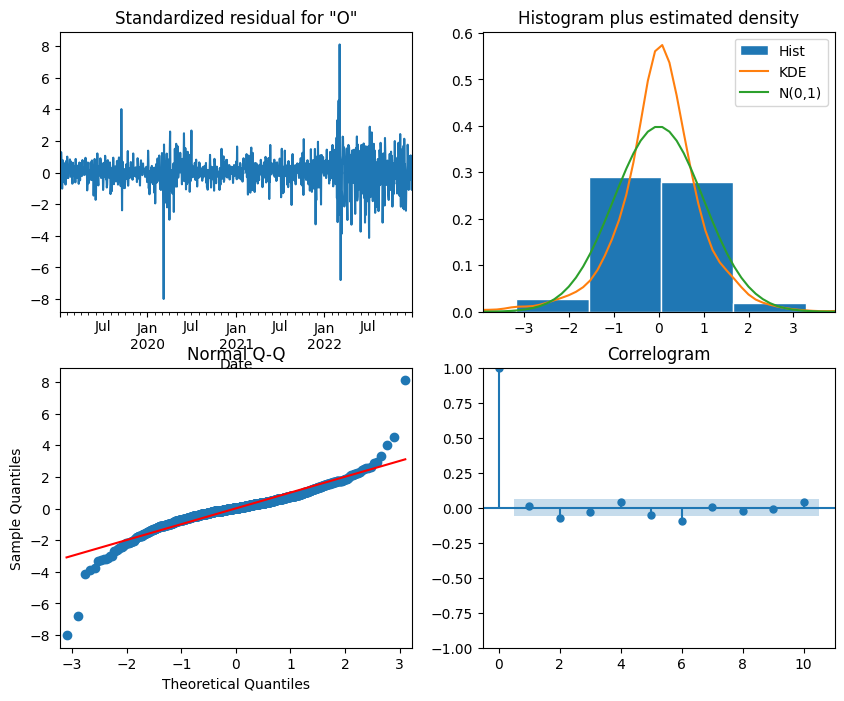

In [17]:
oil_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


In [18]:
# Get in-sample predictions
training_data_predictions = oil_model_fit.get_prediction(start=train_data_oil.dropna().index.min(),
                                                      end=train_data_oil.dropna().index.max(),
                                                      dynamic=False)

train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_oil['Oil predictions'] = training_data_predictions.predicted_mean

train_data_oil

,Original_Oil_Price,lower Oil predictions,Higher Oil predictions,Oil predictions
Date,,,,
2019-01-02,52.14,-1959.966721,1959.966721,0.000000
2019-01-03,52.93,48.865015,55.415020,52.140017
2019-01-04,55.13,49.771705,56.275554,53.023629
2019-01-07,56.42,52.177396,58.668988,55.423192
2019-01-08,56.09,53.443444,59.933541,56.688492
...,...,...,...,...
2022-12-26,82.23,77.247193,83.658265,80.452729
2022-12-27,82.23,79.455459,85.866531,82.660995
2022-12-28,81.96,78.797827,85.208899,82.003363


In [19]:
forecast = oil_model_fit.get_forecast(steps=5, alpha=0.05)
forecast.predicted_mean

2023-01-02    81.399469
2023-01-03    81.576954
2023-01-04    81.412067
2023-01-05    81.552095
2023-01-06    81.490670
Freq: B, Name: predicted_mean, dtype: float64

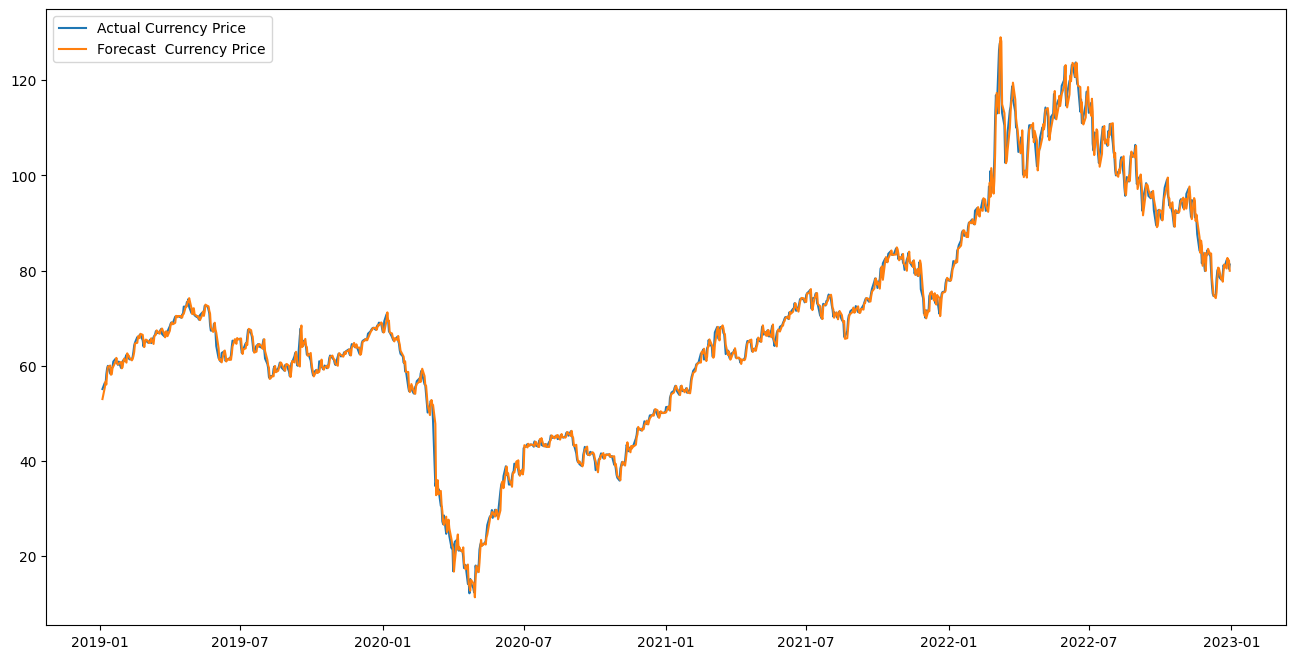

In [24]:
plt.figure(figsize=(16,8))
plt.plot(train_data_oil['Original_Oil_Price'][2:],label="Actual Currency Price")
plt.plot(train_data_oil['Oil predictions'][2:],label="Forecast  Currency Price")
plt.legend(loc="upper left")

In [21]:



# define model configuration
my_order = (1,2,3)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_oil['Original_Oil_Price']]
for i in range(len(test_data_oil['Original_Oil_Price'])):

    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order
    model = ARIMA(history, order=my_order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    history.append(test_data_oil['Original_Oil_Price'][i])

    print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test_data_oil['Original_Oil_Price'].index[i],forecast.predicted_mean[0],test_data_oil['Original_Oil_Price'][test_data_oil['Original_Oil_Price'].index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df_Step1 = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_oil['Original_Oil_Price'].index)



my_order is (1, 2, 3) for date 2023-01-02 00:00:00 and predicted value is 81.31129871381833 and actual value is 82.05 
my_order is (1, 2, 3) for date 2023-01-03 00:00:00 and predicted value is 82.24955877159128 and actual value is 82.05 
my_order is (1, 2, 3) for date 2023-01-04 00:00:00 and predicted value is 81.9592186981254 and actual value is 76.88 
my_order is (1, 2, 3) for date 2023-01-05 00:00:00 and predicted value is 76.38633033046565 and actual value is 75.77 
my_order is (1, 2, 3) for date 2023-01-06 00:00:00 and predicted value is 75.74084910034921 and actual value is 76.15 
my_order is (1, 2, 3) for date 2023-01-09 00:00:00 and predicted value is 76.2131685780819 and actual value is 77.57 
my_order is (1, 2, 3) for date 2023-01-10 00:00:00 and predicted value is 77.75676496281788 and actual value is 77.0 
my_order is (1, 2, 3) for date 2023-01-11 00:00:00 and predicted value is 76.90409560405801 and actual value is 78.23 
my_order is (1, 2, 3) for date 2023-01-12 00:00:00 

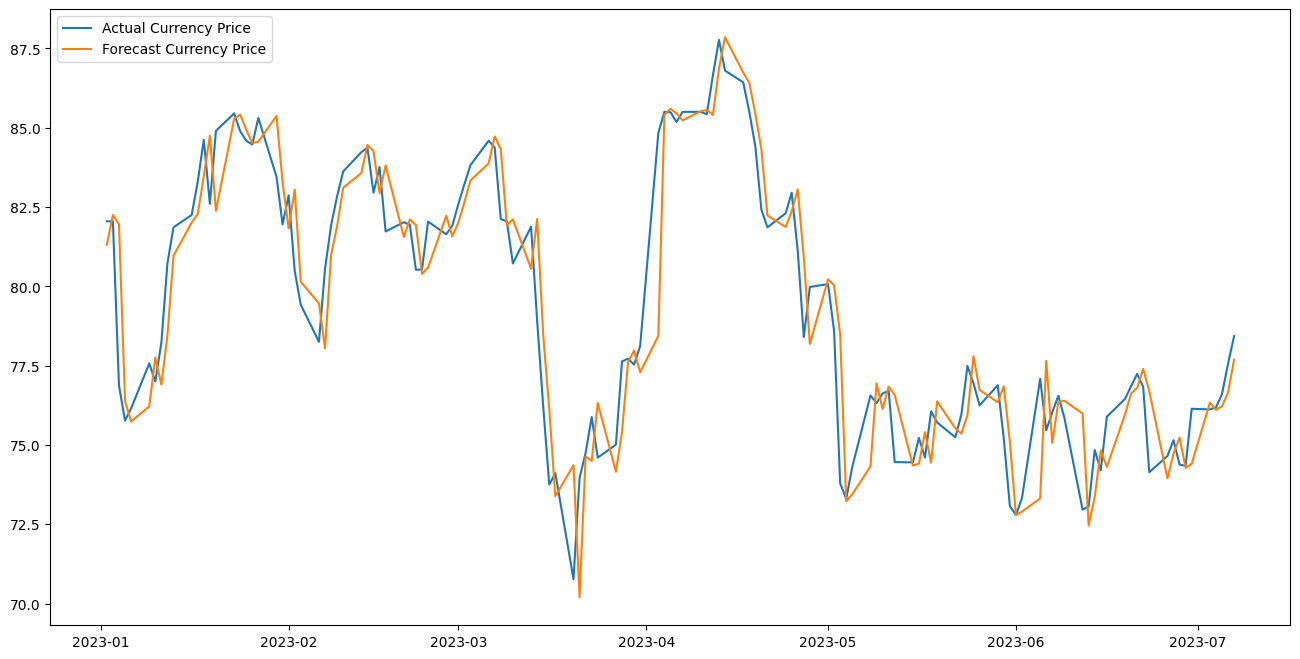

In [25]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df_Step1['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [23]:
# define model configuration
my_order = (1,2,3)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_oil['Original_Oil_Price']]
for i in range(0, len(test_data_oil['Original_Oil_Price']), 5):  # now stepping by 5
    # Commenting below lines a model not predicting any new model , so used the value found earlier
    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order

    model = ARIMA(history, order=my_order)
    model_fit = model.fit()

    # if less than 5 steps remaining, adjust steps to fit
    steps = min(5, len(test_data_oil['Original_Oil_Price']) - i)

    forecast = model_fit.get_forecast(steps=steps, alpha=0.05)

    forecasts.extend(forecast.predicted_mean)  # using extend instead of append

    # Append all forecasted values to the history
    history.extend(test_data_oil['Original_Oil_Price'][i:i+steps])
    print("my_order is {} for Week Starting {} and predicted value is {} and actual value is {}".format(my_order,test_data_oil['Original_Oil_Price'].index[i],forecast.predicted_mean,test_data_oil['Original_Oil_Price'][test_data_oil['Original_Oil_Price'].index[i:i+steps]].values.tolist()))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df_Step5 = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_oil['Original_Oil_Price'].index)


my_order is (1, 2, 3) for Week Starting 2023-01-02 00:00:00 and predicted value is [81.31129871 81.42365173 81.37195462 81.47283803 81.43180863] and actual value is [82.05, 82.05, 76.88, 75.77, 76.15]
my_order is (1, 2, 3) for Week Starting 2023-01-09 00:00:00 and predicted value is [76.21316858 76.23443167 76.2575031  76.27888914 76.30184597] and actual value is [77.57, 77.0, 78.23, 80.73, 81.86]
my_order is (1, 2, 3) for Week Starting 2023-01-16 00:00:00 and predicted value is [82.01155715 82.0072441  82.06567429 82.06549698 82.12006404] and actual value is [82.25, 83.3, 84.62, 82.6, 84.9]
my_order is (1, 2, 3) for Week Starting 2023-01-23 00:00:00 and predicted value is [85.27153078 85.21139957 85.32734375 85.27948785 85.38401251] and actual value is [85.45, 84.89, 84.59, 84.47, 85.31]
my_order is (1, 2, 3) for Week Starting 2023-01-30 00:00:00 and predicted value is [85.37249755 85.44176863 85.43735343 85.50151353 85.50185481] and actual value is [83.45, 81.95, 82.87, 80.48, 79.42]

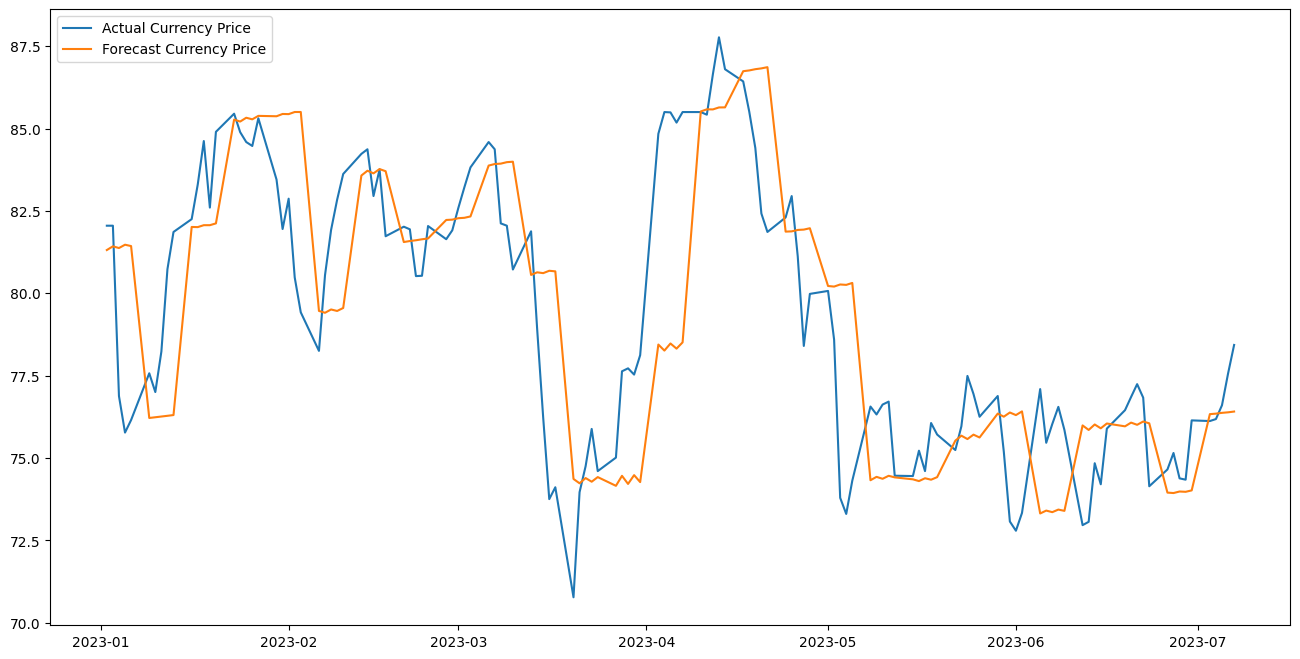

In [26]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df_Step5['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

cur_model=ARIMA(train_data_currency['Original_USD_EUR_Price'],order=(1,2,4),exog=train_data_oil['Original_Oil_Price'])
cur_model_fit=cur_model.fit()
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Original_USD_EUR_Price   No. Observations:                 1043
Model:                     ARIMA(1, 2, 4)   Log Likelihood                4017.187
Date:                    Mon, 10 Jul 2023   AIC                          -8020.374
Time:                            06:55:25   BIC                          -7985.738
Sample:                        01-02-2019   HQIC                         -8007.236
                             - 12-30-2022                                         
Covariance Type:                      opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Original_Oil_Price -4.454e-05   5.56e-05     -0.802      0.423      -0.000    6.44e-05
ar.L1                 -0.7074      6.880     -0.103      0.918     -14.192      12.777
ma.L1                 -0.1269      6.878     -0.018      0.985     -13.608      13.355
ma.L2                 -0.6278      5.740     -0.109      0.913     -11.878      10.623
ma.L3                 -0.0812      0.249     -0.326      0.744      -0.569       0.407
ma.L4                 -0.0364      0.383     -0.095      0.924      -0.787       0.714
sigma2                2.6e-05   8.83e-07     29.466      0.000    2.43e-05    2.77e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.09   Jarque-Bera (JB):               107.91
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
from statsmodels.tsa.arima.model import ARIMA

cur_model=ARIMA(train_data_currency['Original_USD_EUR_Price'],order=(5,1,1),exog=train_data_oil['Original_Oil_Price'])
cur_model_fit=cur_model.fit()
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Original_USD_EUR_Price   No. Observations:                 1043
Model:                     ARIMA(5, 1, 1)   Log Likelihood                4046.879
Date:                    Mon, 10 Jul 2023   AIC                          -8077.758
Time:                            21:44:24   BIC                          -8038.166
Sample:                        01-02-2019   HQIC                         -8062.740
                             - 12-30-2022                                         
Covariance Type:                      opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Original_Oil_Price   -4.8e-05    5.5e-05     -0.872      0.383      -0.000    5.98e-05
ar.L1                  0.0280      2.296      0.012      0.990      -4.473       4.529
ar.L2                  0.0105      0.128      0.082      0.935      -0.241       0.262
ar.L3                 -0.0267      0.034     -0.784      0.433      -0.093       0.040
ar.L4                 -0.0052      0.069     -0.075      0.940      -0.141       0.131
ar.L5                 -0.0119      0.028     -0.425      0.671      -0.067       0.043
ma.L1                  0.0276      2.298      0.012      0.990      -4.476       4.531
sigma2              2.473e-05   8.18e-07     30.228      0.000    2.31e-05    2.63e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               167.68
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

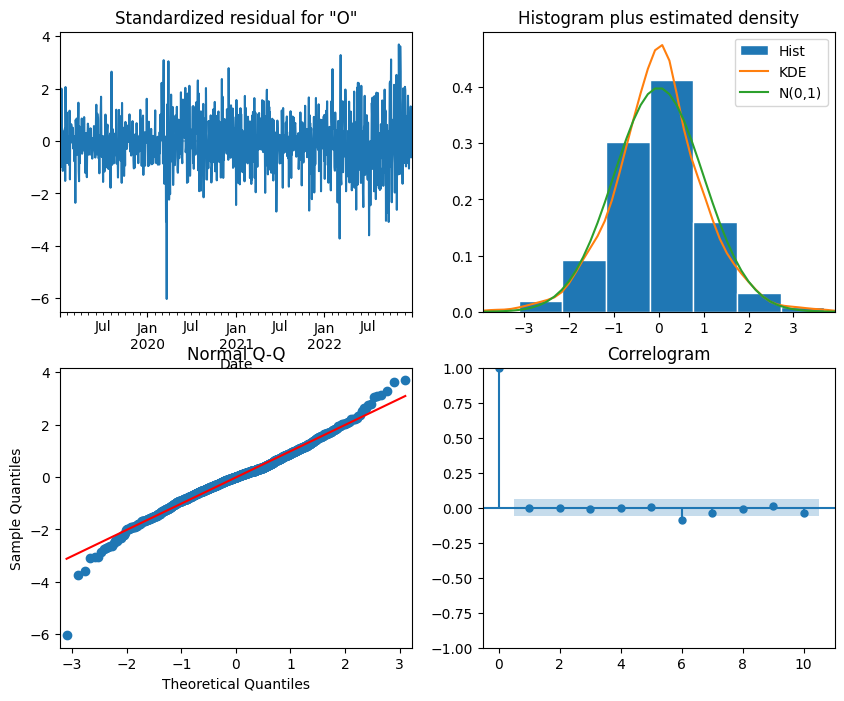

In [31]:
cur_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


In [32]:
# Get in-sample predictions
training_data_predictions = cur_model_fit.get_prediction(start=train_data_currency.dropna().index.min(),
                                                      end=train_data_currency.dropna().index.max(),
                                                      dynamic=False)

train_data_currency[['lower Cur predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_currency['Cur predictions'] = training_data_predictions.predicted_mean

train_data_currency

,Original_USD_EUR_Price,lower Cur predictions,Higher Oil predictions,Cur predictions
Date,,,,
2019-01-02,1.146171,-1959.966487,1959.961482,-0.002503
2019-01-03,1.131811,1.136366,1.155901,1.146133
2019-01-04,1.139108,1.121151,1.140655,1.130903
2019-01-07,1.141044,1.129595,1.149099,1.139347
2019-01-08,1.147974,1.131883,1.151380,1.141631
...,...,...,...,...
2022-12-26,1.066780,1.050469,1.069964,1.060216
2022-12-27,1.064022,1.057390,1.076885,1.067138
2022-12-28,1.063717,1.054205,1.073700,1.063952


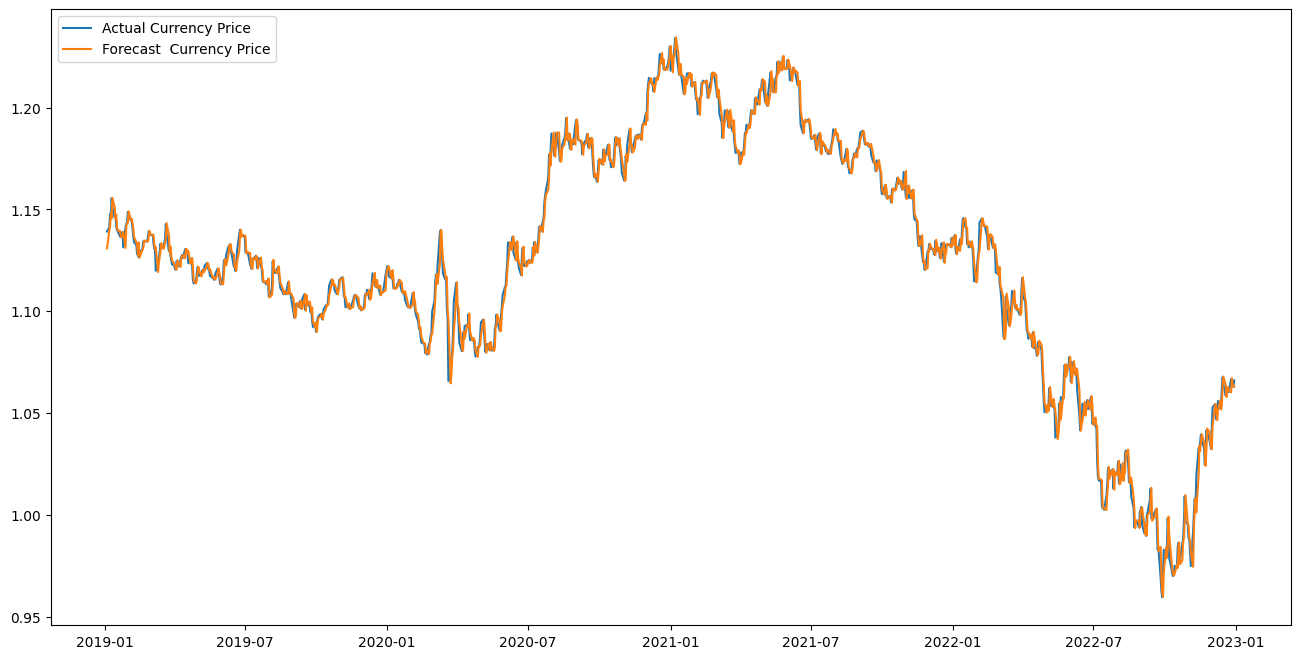

In [33]:
plt.figure(figsize=(16,8))
plt.plot(train_data_currency['Original_USD_EUR_Price'][2:],label="Actual Currency Price")
plt.plot(train_data_currency['Cur predictions'][2:],label="Forecast  Currency Price")
plt.legend(loc="upper left")

In [39]:

forecast_oil=forecast_df_Step1['Forecast']

# lists to collect forecasts
forecasts = []
forecast_dates = []
my_order=(5,1,1)

# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price']]
exog_history = [x for x in train_data_oil['Original_Oil_Price']]

for i in range(len(test_data_currency['Original_USD_EUR_Price'])):
    if i % 5==0:
      #auto = auto_arima(history, error_action='ignore', suppress_warnings=True, d=2)
      #my_order = auto.order


      model = ARIMA(history, order=my_order, exog=np.array(exog_history).reshape(-1,1))
      model_fit = model.fit()

    # Make sure to reshape your exog data for the forecast
    exog_forecast = np.array([forecast_oil[i]]).reshape(-1,1)
    forecast = model_fit.get_forecast(steps=1, alpha=0.05, exog=exog_forecast)
    forecasts.append(forecast.predicted_mean[0])
    history.append(test_data_currency['Original_USD_EUR_Price'].iloc[i])
    exog_history.append(forecast_oil[i])

    print(f"Currency Price {forecast.predicted_mean[0]} & Oil Price {forecast_oil[i]} for date {test_data_currency['Original_USD_EUR_Price'].index[i]} ")

# Create a dataframe to hold the forecasts with corresponding dates
forecast_df_Step1 = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_currency.index)

Currency Price 1.0661882373850624 & Oil Price 81.31129871381833 for date 2023-01-02 00:00:00 
Currency Price 1.066143200603296 & Oil Price 82.24955877159128 for date 2023-01-03 00:00:00 
Currency Price 1.0661571370193446 & Oil Price 81.9592186981254 for date 2023-01-04 00:00:00 
Currency Price 1.0664246374368915 & Oil Price 76.38633033046565 for date 2023-01-05 00:00:00 
Currency Price 1.0664556207416311 & Oil Price 75.74084910034921 for date 2023-01-06 00:00:00 
Currency Price 1.0521146034089783 & Oil Price 76.2131685780819 for date 2023-01-09 00:00:00 
Currency Price 1.052023940352541 & Oil Price 77.75676496281788 for date 2023-01-10 00:00:00 
Currency Price 1.052074021844672 & Oil Price 76.90409560405801 for date 2023-01-11 00:00:00 
Currency Price 1.0519828916179705 & Oil Price 78.4556458606299 for date 2023-01-12 00:00:00 
Currency Price 1.0518354712500892 & Oil Price 80.96557168753783 for date 2023-01-13 00:00:00 
Currency Price 1.086277881950202 & Oil Price 82.01155714590914 for

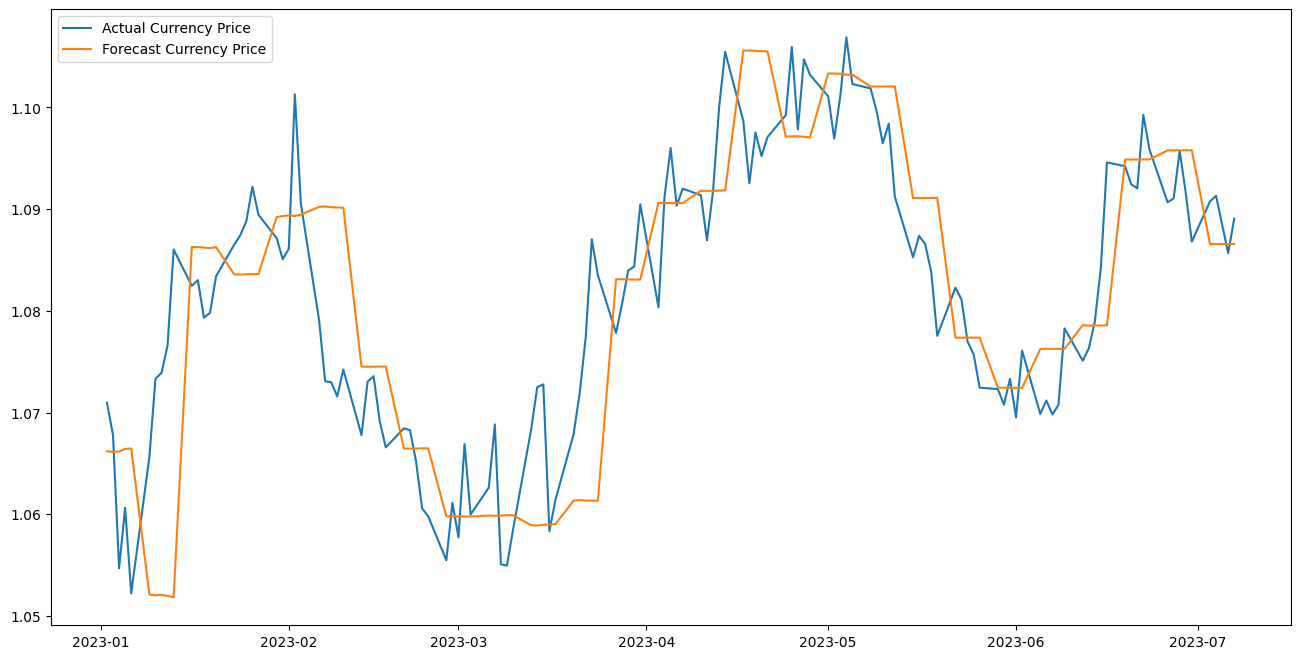

In [36]:

plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df_Step1['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [37]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}



In [38]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.006214229700972892,
 'Mean Squared Error': 7.394170046647043e-05,
 'Root Mean Squared Error': 0.008598936007813434,
 'Mean Absolute Percentage Error': 0.5751106730327271}

In [ ]:
# lists to collect forecasts
forecasts = []
forecast_oil=forecast_df_Step5['Forecast']


# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price']]
exog_history = [x for x in train_data_oil['Original_Oil_Price']]

for i in range(0,len(test_data_currency['Original_USD_EUR_Price']),5):
    auto = auto_arima(history, error_action='ignore', suppress_warnings=True, d=2)
    my_order = auto.order
    model = ARIMA(history, order=my_order, exog=np.array(exog_history).reshape(-1,1))
    model_fit = model.fit()

    steps = min(5, len(test_data_currency['Original_USD_EUR_Price']) - i)
    exog_forecast = np.array([forecast_oil_df['Forecast'][i:i+steps]]).reshape(-1,1)
    forecast = model_fit.get_forecast(steps=steps, alpha=0.05, exog=exog_forecast)
    forecasts.append(forecast.predicted_mean[0])
    history.extend(test_data_currency['Original_USD_EUR_Price'].iloc[i:i+steps].values)
    exog_history.extend(forecast_oil_df['Forecast'][i:i+steps].values)

    print(f"Order is {my_order} ,Actaul Currency Price {test_data_currency['Original_USD_EUR_Price'].iloc[i:i+steps].values.tolist()}, Forecasted Currency Price {forecast.predicted_mean.tolist()} & Forecasted  Oil Price {forecast_oil_df['Forecast'].iloc[i:i+steps].values.tolist()} for week starting {test_data_currency['Original_USD_EUR_Price'].index[i]} ")


# Create a dataframe to hold the forecasts with corresponding dates
forecast_df_Step5 = pd.DataFrame(data={'Forecast': forecasts}, index=train_data_currency['Original_USD_EUR_Price'].index[:len(forecasts)])
